# Exploratory Data Analysis and Feature Engineering for Price Optimization Project
Data Source: https://archive-beta.ics.uci.edu/dataset/352/online+retail

## Import Libraries

In [17]:
import shap # model explainability
import joblib # used to save the model
import pandas as pd # data transformation
import numpy as np # array computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns; sns.set() # data visualization

# Model Preparation and Preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import RocCurveDisplay, classification_report,confusion_matrix
from sklearn import metrics

/Users/drjodyannjones/opt/anaconda3/envs/price_optimization/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/drjodyannjones/opt/anaconda3/envs/price_optimization/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

## Load Dataset

In [2]:
data = pd.read_csv('../data/online_retail.csv')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
print("The shape of the data is: ", data.shape)

The shape of the data is:  (541909, 8)


## Check for missing values

In [5]:
data.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [6]:
# Approximately 24% of Customer ID is missing.
data.isna().sum()/len(data)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

## Handle missing values (imputation, deletion, etc.)

## Check for duplicate entries

In [7]:
# Approximately .97% of the data is duplicated.
data.duplicated().sum()/len(data)*100

0.9721189350979592

## Handle duplicate entries

## Handle outliers (capping, transformation, etc.)

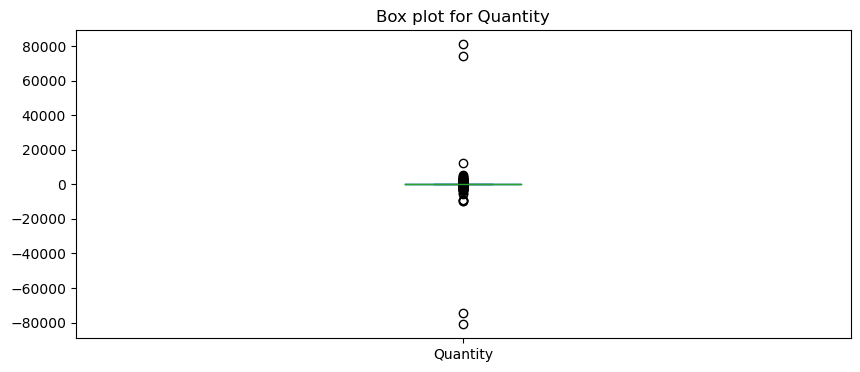

In [8]:
# Box plot for Quantity
plt.figure(figsize=(10,4))
plt.title("Box plot for Quantity")
data['Quantity'].plot(kind='box')
plt.show()

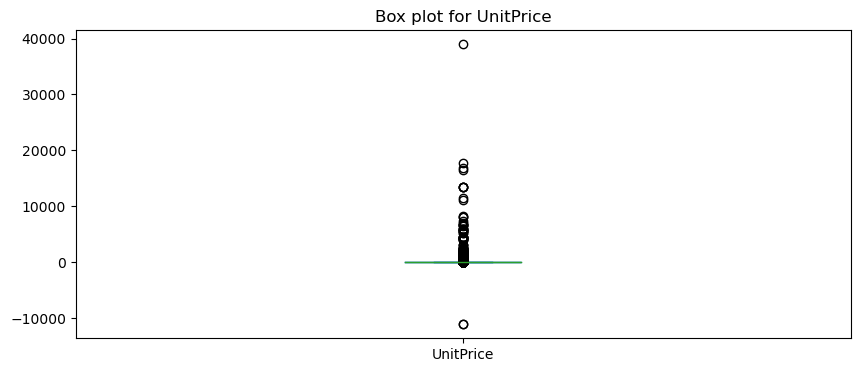

In [9]:
# Box plot for UnitPrice
plt.figure(figsize=(10,4))
plt.title("Box plot for UnitPrice")
data['UnitPrice'].plot(kind='box')
plt.show()

## Check cardinality of categorical variables

In [10]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

## Handle categorical variables (convert incorrect dtypes, one-hot encoding, label encoding, etc. where necessary)

In [11]:
# There are 5 variables with object data types
# We will perform the following operations:
# InvoiceDate will be converted to date type
# Some variables that will not directly contribute to the model will be dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

## Normalize/standardize numerical variables

In [13]:
# CustomerID should actually be a string and not a float
# This leaves two numerical variables: Quantity and UnitPrice
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Conduct univariate analysis

In [14]:
data.describe(include='all').round(2).T

/var/folders/hf/r7nc2r613218f_z6flzjpd8h0000gn/T/ipykernel_5398/1673793071.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all').round(2).T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,NaT,NaT,9.55,218.08,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaN,NaN,NaT,NaT,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaN,NaN,NaT,NaT,15287.69,1713.6,12346.0,13953.0,15152.0,16791.0,18287.0
Country,541909,38,United Kingdom,495478,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Conduct bivariate analysis

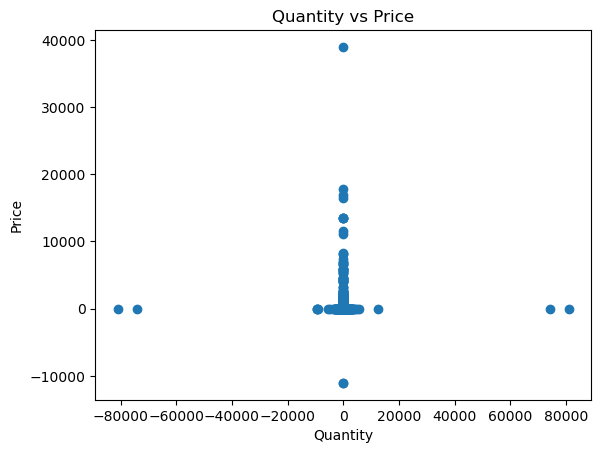

In [15]:
# Bivariate analysis of 'quantity' and 'price'
plt.scatter(data['Quantity'], data['UnitPrice'])
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Quantity vs Price')
plt.show()

## Visualize distributions, correlations, and patterns
- For distributions, we will use histograms
- For correlations, we will use heatmaps